In [1]:
import numpy as np
import torch

from settings import *
from device import device
from autoencoder import Encoder, Decoder, Autoencoder
from dataloader import build_autoencoder_dataloader, build_stepper_dataloader
from stepper import Stepper
from trainer import fit

from utils import load_video, img_display, img_save

device: mps


torch.Size([100, 3, 360, 640]) tensor(0.0702, device='mps:0') tensor(0.0750, device='mps:0')


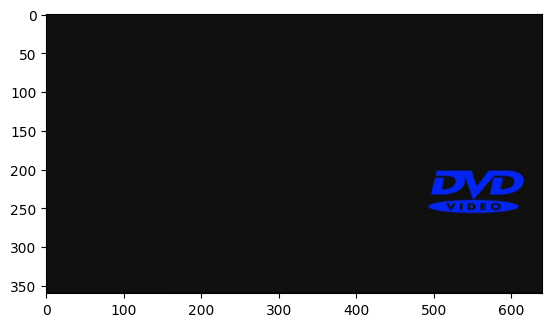

In [2]:
frames = load_video(video_path, start=0, num_frames=100, num_frames_per_frame=5)

print(frames.shape, frames.mean(), frames.std())

img_display(frames[0])


In [3]:
encoder = Encoder().to(device)
decoder = Decoder().to(device)

autoencoder = Autoencoder(encoder, decoder).to(device)

In [4]:
autoencoder_dataloader = build_autoencoder_dataloader(frames)

print(len(autoencoder_dataloader))

6


In [5]:
autoencoder_criterion = torch.nn.MSELoss()
autoencoder_optimizer = torch.optim.AdamW(autoencoder.parameters(), lr=3e-4)

def autoencoder_after_batch(self, firing, epoch_idx, batch_idx, batch_loss, batch_xs, batch_outputs):
    setattr(self, 'running_loss', getattr(self, 'running_loss', 0) + batch_loss)
    
    if firing:

        print(f'Epoch: {epoch_idx}, Batch: {batch_idx}, Loss: {self.running_loss / (batch_idx + 1)}')

        img_save(batch_xs[0], 'input.png')
        img_save(batch_outputs[0], 'output.png')


def autoencoder_after_epoch(self, firing, epoch_idx, loss):
    if firing:
        print(f'Epoch: {epoch_idx}, Loss: {loss}')

fit(autoencoder, autoencoder_criterion, autoencoder_optimizer, autoencoder_dataloader, 1, autoencoder_after_batch, autoencoder_after_epoch)

Epoch: 0, Batch: 0, Loss: 0.010377153754234314
Epoch: 0, Loss: 0.009527354501187801
Training completed


In [6]:
stepper = Stepper(encoder, decoder).to(device)

In [7]:
stepper_dataloader = build_stepper_dataloader(frames)

print(len(stepper_dataloader))

13


In [8]:
stepper_criterion = torch.nn.MSELoss()
stepper_optimizer = torch.optim.AdamW(stepper.parameters(), lr=3e-4)

def stepper_after_batch(self, firing, epoch_idx, batch_idx, batch_loss, batch_xs, batch_outputs):
    setattr(self, 'running_loss', getattr(self, 'running_loss', 0) + batch_loss)
    
    if firing:

        print(f'Epoch: {epoch_idx}, Batch: {batch_idx}, Loss: {self.running_loss / (batch_idx + 1)}')

        img_save(batch_xs[-1][-1], 'input.png')
        img_save(batch_outputs[-1][-1], 'output.png')


def stepper_after_epoch(self, firing, epoch_idx, loss):
    if firing:
        print(f'Epoch: {epoch_idx}, Loss: {loss}')

fit(stepper, stepper_criterion, stepper_optimizer, stepper_dataloader, 4, stepper_after_batch, stepper_after_epoch)

Epoch: 0, Batch: 0, Loss: 0.007632616441696882
Epoch: 0, Batch: 8, Loss: 0.009654658225675425
Epoch: 0, Loss: 0.010625392198562622
Epoch: 1, Batch: 3, Loss: 0.03864473570138216
Epoch: 1, Batch: 11, Loss: 0.01760488053938995
Epoch: 2, Batch: 7, Loss: 0.03366979013662785
Epoch: 3, Batch: 2, Loss: 0.10518892544011275
Epoch: 3, Batch: 9, Loss: 0.03563750209286809
Epoch: 3, Loss: 0.008183272555470467
Training completed


In [9]:
torch.save(stepper.state_dict(), "stepper.pt")

In [10]:
# stepper.load_state_dict(torch.load("stepper.pt"))

In [13]:
new_frames = stepper.generate(frames, 50)

RuntimeError: MPS backend out of memory (MPS allocated: 20.33 GB, other allocations: 8.36 MB, max allowed: 20.40 GB). Tried to allocate 290.04 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

In [12]:
from utils import write_video


write_video(new_frames, 'output.mp4')

(150, 360, 640, 3)
14.344970264274691 16.593731823296938
